In [1]:
pip install -q -U keras_tuner

     |████████████████████████████████| 98 kB 3.3 MB/s 


In [20]:
# Import libraries
import sys, glob, os, time
import numpy as np
import scipy as sp
import pandas as pd
from csv import reader, writer
import joblib
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Activation, Input, Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Reshape, LeakyReLU
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.generic_utils import get_custom_objects
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython import display

get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})

In [3]:
# Activate GPU
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# current working directory
cwd = '/content/drive/MyDrive/Colab Notebooks/Daylight Autonomy/'

# Data setup

In [11]:
features_file = os.path.join(cwd, 'data', 'DA_features.csv')
targets_file = os.path.join(cwd, 'data', 'DA_targets.csv')

In [12]:
raw_features = pd.read_csv(features_file, index_col=0)
raw_targets = pd.read_csv(targets_file)

In [13]:
minmax = np.array([[-10,10], [-10,10], [-10,10], [-10,10],
                   [-10,10], [-10,10], [-10,10], [-10,10],
                   [2,5], [0.2,0.95], [0.2,0.95], [0,360]])

In [14]:
f_avg = minmax.mean(axis=1)
f_std = minmax.std(axis=1)
t_std = 1

features = (raw_features - f_avg)/f_std
targets = raw_targets/t_std

In [15]:
features = np.array(features)
targets = np.array(targets).reshape(len(targets),40,40)

In [16]:
# Split data to train, validate, test set (60% training, 20% validation, 20% test split)
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [17]:
n_feat = features.shape[1]
n_tar = targets.shape[1]

# Model and training

In [18]:
# Clear keras workspace for new model
keras.backend.clear_session()

# Deconvolutional Neural Network Model (DCNN) for generating daylight autonomy
model = Sequential()

### DNN model to analysis the input parameters
model.add(Dense(32 * 6 * 6, input_dim=n_feat))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(256 * 6 * 6))
model.add(BatchNormalization())
model.add(LeakyReLU())

### Deconvolution to generate image
model.add(Reshape((6, 6, 256)))

model.add(Conv2DTranspose(filters=128, kernel_size=5, strides=(2,2), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64, kernel_size=5, strides=(2,2), activation='leaky-relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64, kernel_size=5, strides=(1,1), activation='leaky-relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64, kernel_size=5, strides=(1,1), activation='leaky-relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=1, kernel_size=2, strides=(1,1), activation='sigmoid'))

# optimizer
model.compile(optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.5, beta_2=0.999), loss="mse")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1152)              14976     
                                                                 
 batch_normalization (BatchN  (None, 1152)             4608      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1152)              0         
                                                                 
 dense_1 (Dense)             (None, 9216)              10626048  
                                                                 
 batch_normalization_1 (Batc  (None, 9216)             36864     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 9216)              0

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs = 3000,
    batch_size = 8,
    validation_data = (X_val, y_val),
    callbacks = [
                 EarlyStopping(monitor='val_loss', patience=50, mode='min'),
                 ModelCheckpoint(filepath = 'CNN2D.ckpt', save_weights_only=True, monitor='val_loss', save_best_only=True)
    ]
)

Epoch 1/3000
120/120 [==============================] - 3s 14ms/step - loss: 0.0509 - val_loss: 0.0798
Epoch 2/3000
120/120 [==============================] - 2s 15ms/step - loss: 0.0354 - val_loss: 0.0567
Epoch 3/3000
120/120 [==============================] - 1s 12ms/step - loss: 0.0308 - val_loss: 0.0313
Epoch 4/3000
120/120 [==============================] - 1s 11ms/step - loss: 0.0281 - val_loss: 0.0231
Epoch 5/3000
120/120 [==============================] - 1s 12ms/step - loss: 0.0266 - val_loss: 0.0197
Epoch 6/3000
120/120 [==============================] - 1s 9ms/step - loss: 0.0259 - val_loss: 0.0222
Epoch 7/3000
120/120 [==============================] - 1s 9ms/step - loss: 0.0246 - val_loss: 0.0235
Epoch 8/3000
120/120 [==============================] - 1s 9ms/step - loss: 0.0239 - val_loss: 0.0216
Epoch 9/3000
120/120 [==============================] - 1s 9ms/step - loss: 0.0235 - val_loss: 0.0205
Epoch 10/3000
120/120 [==============================] - 1s 9ms/step - loss: 

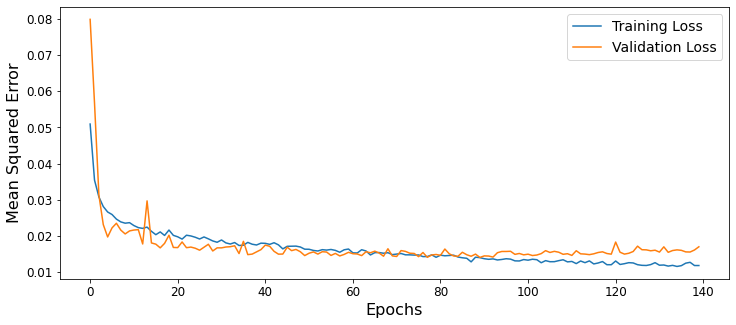

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.ylabel('Mean Squared Error',fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.legend(fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.show()

In [ ]:
model.load_weights('CNN2D.ckpt');

In [ ]:
y_pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test.reshape(-1, 40*40), y_pred.reshape(-1, 40*40)))

0.11931360518452323

In [ ]:
k = 78
q = 150

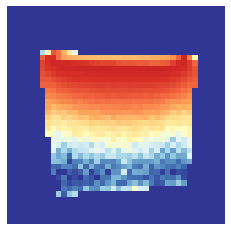

In [ ]:
plt.imshow(y_test[k], cmap='RdYlBu_r', vmax=1, vmin=0)
plt.axis('off');

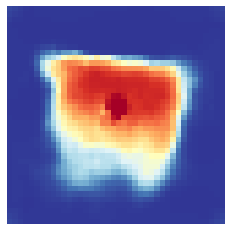

In [ ]:
plt.imshow(y_pred[k].reshape(40,-1), cmap='RdYlBu_r', vmax=1, vmin=0)
plt.axis('off');

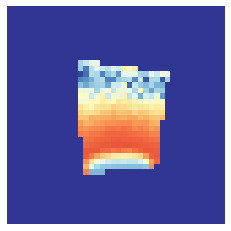

In [ ]:
plt.imshow(y_train[q], cmap='RdYlBu_r', vmax=1, vmin=0)
plt.axis('off');

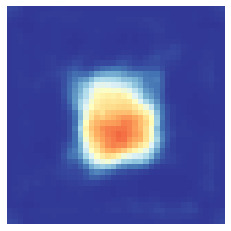

In [ ]:
y_train_pred = model.predict(X_train)
plt.imshow(y_train_pred[q].reshape(40,-1), cmap='RdYlBu_r', vmax=1, vmin=0)
plt.axis('off');

In [ ]:
np.sqrt(mean_squared_error(y_test[k],y_pred[k].reshape(40,-1)))

0.17040203429900072

In [ ]:
results = [np.sqrt(mean_squared_error(y_test[k],y_pred[k].reshape(40,-1))) for k in range(len(y_test))]    

In [ ]:
# best result
results.index(min(results))

200

In [ ]:
# worst result
results.index(max(results))

48

#Hyperparameter Tuning

In [12]:
def construct_layers(hp,n_inputs):
    layers = []
    out = n_inputs
    i = 1

    while out < 40:
        if out < 36:
            ins = {"input":out,
                "kernel":hp.Int('kernel_' + str(i), min_value=2, max_value=5),
                "stride":1,
                "activation":hp.Choice('CNN_act_' + str(i), values=['tanh','relu', 'selu', 'leaky-relu']),
                "filter":hp.Int('filter_'+str(i), min_value=16, max_value=128, step=16)
                }
        else:
            ins = {"input":out,
                "kernel":41 - out,
                "stride":1,
                "activation":'None',
                "filter":1
                }
        out = (out-1) * ins["stride"] + ins["kernel"]
        i += 1
        ins.update({"output":out})
        layers.append(ins)
    
    return layers

In [13]:
def generator(hp):
    # Generator model for generating daylight autonomy
    model = Sequential()

    # Setup DNN layers
    DNN_layers = hp.Int('DNN_layers', min_value=0, max_value=4)

    # Setup CNN transpose layers
    hp_initsize = hp.Int('init_size', min_value=5, max_value=9)
    CNN_layers = construct_layers(hp, hp_initsize)

    ### DNN model to analyze the input parameters
    if DNN_layers == 0:
        model.add(Dense(units = CNN_layers[0]["filter"] * hp_initsize * hp_initsize, 
                        activation=hp.Choice('DNN_act_0', values=['tanh', 'relu', 'leaky-relu', 'sigmoid', 'selu']),
                        input_dim=n_feat))
        model.add(BatchNormalization())
    else:
        for i in range(DNN_layers):
            if i == 0:
                model.add(Dense(units = hp.Int('units_' + str(i+1), min_value=16, max_value=256, step=16),
                                activation=hp.Choice('DNN_act_' + str(i+1), values=['relu', 'leaky-relu', 'sigmoid', 'selu']),
                                input_dim=n_feat))
                model.add(BatchNormalization())
            else:
                model.add(Dense(units = hp.Int('units_' + str(i+1), min_value=16, max_value=256, step=16),
                        activation=hp.Choice('DNN_act_' + str(i+1), values=['relu', 'leaky-relu', 'sigmoid', 'selu'])))
                model.add(BatchNormalization())
        model.add(Dense(units = CNN_layers[0]["filter"] * hp_initsize * hp_initsize, 
                        activation=hp.Choice('DNN_act_0', values=['relu', 'leaky-relu', 'sigmoid', 'selu'])))
        model.add(BatchNormalization())

    ### Deconvolution to generate image
    model.add(Reshape((hp_initsize, hp_initsize, CNN_layers[0]["filter"])))

    for layer in CNN_layers[:-1]:
        model.add(Conv2DTranspose(filters=layer["filter"],
                                  kernel_size=layer["kernel"],
                                  strides=(layer["stride"],layer["stride"]),
                                  activation=layer["activation"]))
        model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(filters=CNN_layers[-1]["filter"],
                              kernel_size=CNN_layers[-1]["kernel"],
                              strides=(CNN_layers[-1]["stride"],CNN_layers[-1]["stride"])
                              # , activation='sigmoid'
                              ))

    ### Optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    hp_epsilon = hp.Choice('epsilon', values=[1e-4, 1e-6, 1e-8])
    hp_beta_1 = hp.Choice('beta_1', values=[0.5, 0.7, 0.9])
    hp_beta_2 = hp.Choice('beta_2', values=[0.99, 0.995, 0.999])
    model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate, 
                                            beta_1=hp_beta_1, beta_2=hp_beta_2,
                                            epsilon=hp_epsilon), 
                  loss="mse"
                  )
    # model.compile(optimizer=optimizers.Adam(learning_rate=1e-3, 
    #                                         beta_1=0.9, beta_2=0.999,
    #                                         epsilon=1e-8), 
    #               loss="mse"
    #               )

    return model

In [14]:
keras.backend.clear_session()

In [ ]:
hp = kt.HyperParameters()
hp.values["model_type"] = "cnn"

model = generator(hp)
model(X_train)
model.summary()

In [16]:
tuner = kt.BayesianOptimization(generator, 
                                objective='val_loss',
                                max_trials=100,
                                overwrite=True)

In [17]:
tuner.search(X_train,
             y_train,
             epochs = 100,
             batch_size = 16,
             validation_data = (X_val, y_val),
             callbacks=[EarlyStopping(monitor='val_loss', patience=30, mode='min')],
             )

Trial 49 Complete [00h 02m 11s]
val_loss: 72.83892822265625

Best val_loss So Far: 69.68326568603516
Total elapsed time: 05h 46m 34s


KeyboardInterrupt: ignored

In [18]:
best_model = tuner.get_best_models()[0]
best_hp = tuner.get_best_hyperparameters()[0]

In [ ]:
model = tuner.hypermodel.build(best_hp)
model.summary()

In [9]:
class GenerateImage(keras.callbacks.Callback):
    def __init__(self, xtrain, ytrain, xtest, ytest, monitor_idx):
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.xtest = xtest
        self.ytest = ytest
        self.monitor_idx = [monitor_idx]
    
    def on_epoch_end(self, epoch, logs={}):
        train_sim = self.ytrain[self.monitor_idx]
        train_pred = self.model.predict(self.xtrain[self.monitor_idx])
        test_sim = self.ytest[self.monitor_idx]
        test_pred = self.model.predict(self.xtest[self.monitor_idx])

        fig, ax = plt.subplots(2, 2, figsize=(6, 6))
        display.clear_output(wait=True)

        ax[0, 0].imshow(train_pred[0,:,:,0], cmap='RdYlBu_r', vmin=0, vmax=100)
        ax[0, 1].imshow(train_sim[0,:,:], cmap='RdYlBu_r', vmin=0, vmax=100)
        ax[1, 0].imshow(test_pred[0,:,:,0], cmap='RdYlBu_r', vmin=0, vmax=100)
        ax[1, 1].imshow(test_sim[0,:,:], cmap='RdYlBu_r', vmin=0, vmax=100)

        ax[0,0].set_title('Prediction', size=12)
        ax[0,1].set_title('Simulation', size=12)
        ax[0,0].set_ylabel('Train Sample', size=12)
        ax[1,0].set_ylabel('Test Sample', size=12)

        ax=ax.ravel()
        for a in ax:
            a.set_xticklabels([])
            a.set_yticklabels([])
            a.set_xticks([])
            a.set_yticks([])
        
        plt.savefig(os.path.join(cwd, 'images', 'generated_img', 'image_at_epoch_{:04d}.png'.format(epoch)))
        plt.show()
        plt.close()

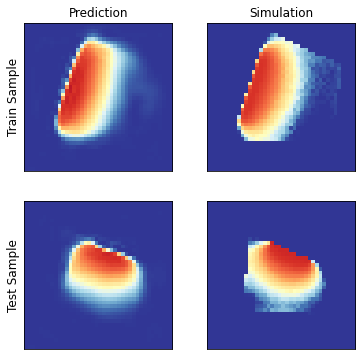

75/75 [==============================] - 1s 17ms/step - loss: 41.0017 - val_loss: 62.1972


In [44]:
model.fit(X_train,
             y_train,
             epochs = 3000,
             batch_size = 16,
             validation_data = (X_val, y_val),
             callbacks = [EarlyStopping(monitor='val_loss', patience=100, mode='min'),
                          ModelCheckpoint(filepath = 'CNN2D.ckpt', save_weights_only=True, monitor='val_loss', save_best_only=True),
                          GenerateImage(X_train, y_train, X_test, y_test, [95])
                          ]
          )

In [45]:
model.load_weights('CNN2D.ckpt');

In [46]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [47]:
test_results = [np.sqrt(mean_squared_error(y_test[k],y_pred[k].reshape(40,-1))) for k in range(len(y_test))]

In [54]:
def compare_plot(sim, pred):
    results = [np.sqrt(mean_squared_error(sim[k],pred[k].reshape(40,-1))) for k in range(len(sim))]

    best_mse = min(results)
    best_idx = results.index(best_mse)

    mid_mse = np.mean(results)
    mid_idx = min(range(len(results)), key=lambda i: abs(results[i]-mid_mse))

    worst_mse = max(results)
    worst_idx = results.index(worst_mse)

    fig, ax = plt.subplots(3,2,sharex=True, sharey=True, figsize=(7,10))

    ax[0,0].imshow(sim[best_idx], cmap='RdYlBu_r', vmax=100, vmin=0)
    ax[0,0].set_title('Simulation', size=15)
    ax[0,0].set_ylabel('Best Case: MSE={:.3f}'.format(best_mse), size=15)

    ax[0,1].imshow(pred[best_idx].reshape(40,-1), cmap='RdYlBu_r', vmax=100, vmin=0)
    ax[0,1].set_title('Prediction', size=15)

    ax[1,0].imshow(sim[mid_idx], cmap='RdYlBu_r', vmax=100, vmin=0)
    ax[1,0].set_ylabel('Avg Case: MSE={:.3f}'.format(mid_mse), size=15)

    ax[1,1].imshow(pred[mid_idx].reshape(40,-1), cmap='RdYlBu_r', vmax=100, vmin=0)

    ax[2,0].imshow(sim[worst_idx], cmap='RdYlBu_r', vmax=100, vmin=0)
    ax[2,0].set_ylabel('Worst Case: MSE={:.3f}'.format(worst_mse), size=15)

    ax[2,1].imshow(pred[worst_idx].reshape(40,-1), cmap='RdYlBu_r', vmax=100, vmin=0)

    ax=ax.ravel()
    for a in ax:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.set_xticks([])
        a.set_yticks([])

    plt.tight_layout()

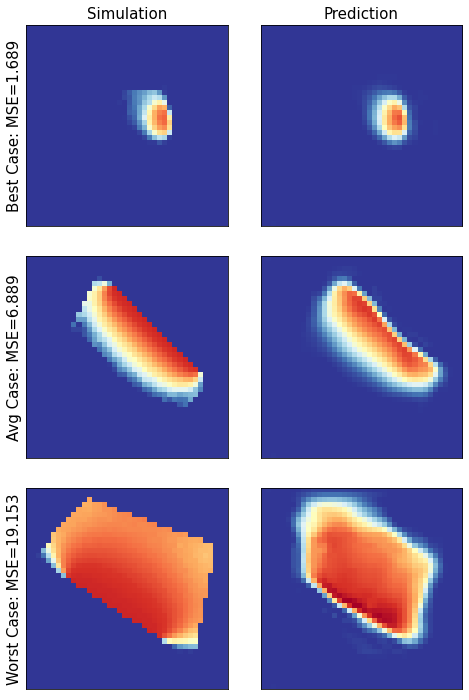

In [55]:
compare_plot(y_test, y_pred)

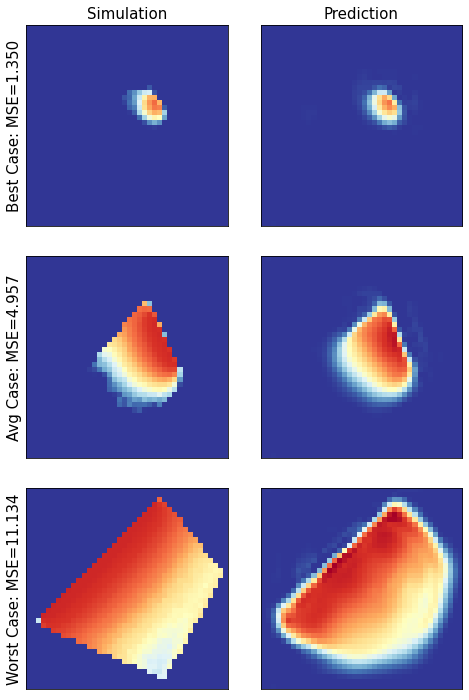

In [56]:
compare_plot(y_train, y_train_pred)

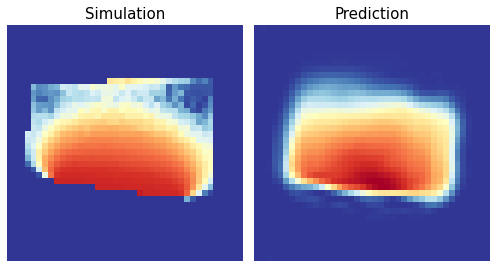

In [53]:
# for k in range(0,200,10):
k=92
fig,ax = plt.subplots(1,2,figsize=(7,14))
ax[0].imshow(y_test[k], cmap='RdYlBu_r', vmax=100, vmin=0)
ax[0].set_title('Simulation', size=15)
ax[0].axis(False)
ax[1].imshow(y_pred[k].reshape(40,-1), cmap='RdYlBu_r', vmax=100, vmin=0)
ax[1].set_title('Prediction', size=15)
ax[1].axis(False);
plt.tight_layout()

Text(0.5, 1.0, 'Prediction')

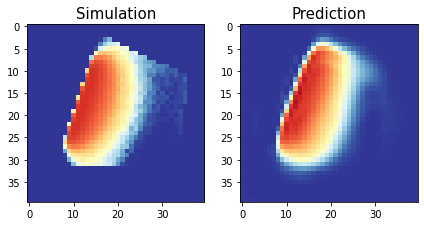

In [52]:
q=95
fig,ax = plt.subplots(1,2,figsize=(7,14))
ax[0].imshow(y_train[q], cmap='RdYlBu_r', vmax=100, vmin=0)
ax[0].set_title('Simulation', size=15)
ax[1].imshow(y_train_pred[q].reshape(40,-1), cmap='RdYlBu_r', vmax=100, vmin=0)
ax[1].set_title('Prediction', size=15)

# Save model

In [5]:
json = os.path.join(cwd, 'models/DA_Bayes.json')
hdf5 = os.path.join(cwd, 'models/DA_Bayes.h5')

In [ ]:
model_json = model.to_json()
with open(json,'w') as json_file:
    json_file.write(model_json)
model.save_weights(hdf5)

# Load Model

In [29]:
keras.backend.clear_session()

In [30]:
json_file = open(json, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json, custom_objects={'Activation': Activation(LeakyReLU())})
model.load_weights(hdf5)

In [ ]:
model.predict(X_train[[0]])

# Test for random input

In [67]:
test_case = np.array([ 5.184285, 3.889452, -2.694362, 2.888376, -7.354871, -1.739963, 2.785612, -3.761489, 2.76, 0.933, 0.92, 360-7.241])
# test_case = np.array([-4.896442, 2.974077, -1.404263, -5.554127, 4.011683, -4.089827, 5.595799, 1.227725, 2.017164, 0.272348, 0.835891, 247.731598])
test_case = (test_case - f_avg)/f_std

# test_pred = model.predict(np.expand_dims(test_case, axis=0))[0].reshape(1,-1)
test_pred = model.predict(test_case.reshape(1,-1))

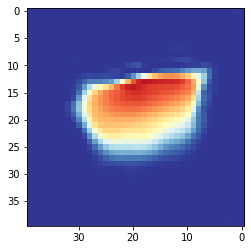

In [68]:
plt.imshow(test_pred.reshape(40,-1), cmap='RdYlBu_r', vmax=100, vmin=0)
plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()

In [ ]:
-4.896442,2.974077,-1.404263,-5.554127,4.011683,-4.089827,5.595799,1.227725,

In [63]:
raw_features[]

,x1,y1,x2,y2,x3,y3,x4,y4,RoomHeight,WindowWidth,WindowHeight,WindowOrientation
Seed,,,,,,,,,,,,
1,-0.527714,-7.109235,7.015081,-1.268206,2.644516,6.620139,-6.963455,1.526437,3.977986,0.423362,0.794236,142.246331
2,-2.185450,8.245618,-7.583210,-3.906574,5.846530,-6.211642,8.443733,-1.212344,4.932242,0.893295,0.339514,293.949835
3,-1.816835,-6.032613,5.906006,-2.193717,2.070175,5.950435,-5.439029,-3.179664,2.612324,0.473454,0.275101,153.568796
4,5.976135,2.273599,0.456680,6.377687,-6.308283,1.043555,-0.471048,-6.376641,4.771164,0.910455,0.792188,36.633296
5,4.745379,6.878263,-8.334696,-0.601635,-2.482803,-7.979023,7.519925,-3.644152,2.136205,0.917304,0.508930,330.236729
...,...,...,...,...,...,...,...,...,...,...,...,...
1996,3.177705,-6.007188,6.564435,1.758496,-5.471881,4.030215,-6.794366,0.143893,4.630933,0.602038,0.399084,113.562731
1997,-3.757553,-2.013184,-1.703976,-3.907503,3.662094,-2.182014,0.464210,4.237526,2.752816,0.918671,0.237995,222.689943
1998,4.662498,-1.396811,3.840763,2.989733,-4.867083,-0.038364,2.723250,-4.034090,2.553054,0.819453,0.606569,79.389710
